
# Классификация изображений автомобилей

### Основная идея этого решения: взять предобученую на ImageNet сеть EfficientNet и дообучить под нашу задачу. 


In [ ]:
from google.colab import files
files.upload();

In [ ]:
#для Colab: скачиваем данные https://www.kaggle.com/c/sf-dl-2-car-classification
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c sf-dl-car-classification
!mkdir -p /kaggle/input/sf-dl-car-classification
!mv /content/* /kaggle/input/sf-dl-car-classification

In [ ]:
!ls /kaggle/input/sf-dl-car-classification

In [ ]:
!nvidia-smi

In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
#! pip install imgaug '0.2.6'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

#предобученная модель efficientnet
import efficientnet.tfkeras as efn 
from sklearn.model_selection import train_test_split, StratifiedKFold

#библиотека для аугментации
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("..content/kaggle/input/sf-dl-car-classification"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = "kaggle/input/sf-dl-car-classification/"
PATH = "kaggle/working/car/" # рабочая директория

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH +data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


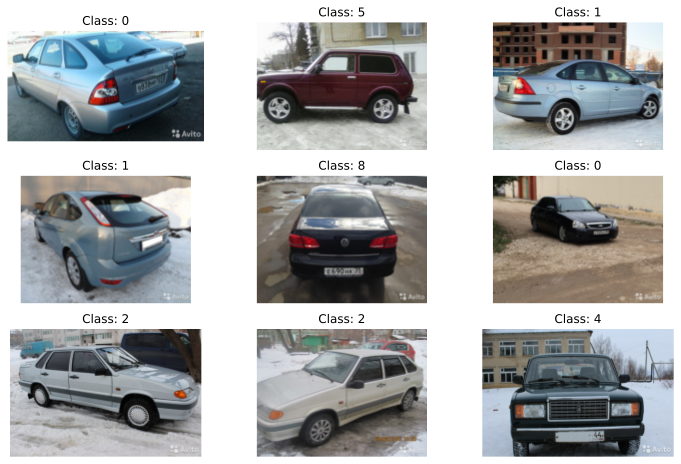

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

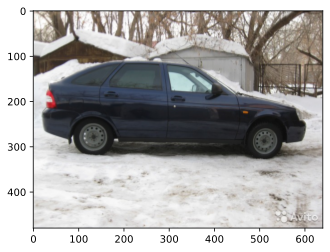

(640, 480)

In [ ]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [ ]:
#можно использовать аугментацию Keras:

#train_datagen = ImageDataGenerator(
#    rescale=1. / 255,
#    rotation_range = 5,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    zoom_range=0.1,
#    validation_split=VAL_SPLIT, # set validation split
#    horizontal_flip=False)
#
#test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

In [ ]:



AUGMENTATIONS = albumentations.Compose([
    albumentations.Transpose(p=0.001),
    albumentations.HorizontalFlip(p=0.4),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1)
    ],p=0.4),
    albumentations.JpegCompression(quality_lower=4, quality_upper=100, p=0.02),
    albumentations.RandomGamma(gamma_limit=20, p=0.02),
    albumentations.RandomContrast(limit=0.3, p=0.3),
    albumentations.HueSaturationValue(p=0.2),
])

In [ ]:
train_datagen = ImageDataAugmentor(
        
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split = VAL_SPLIT,
        preprocess_input=None)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


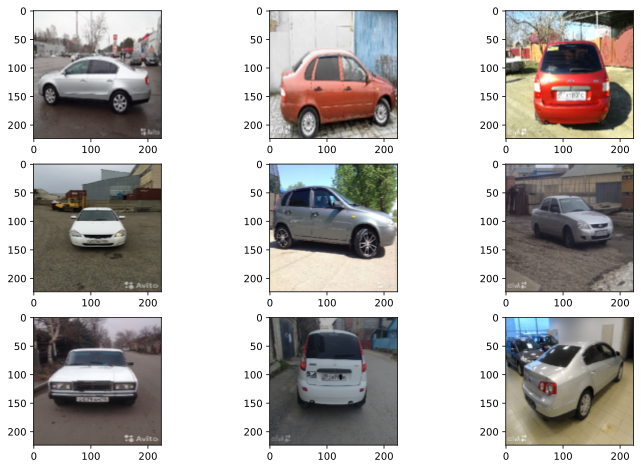

In [ ]:
x, y = train_generator.next()
plt.figure(figsize = (12, 8))
for i in range(0, 9):
    image = x[i]
    plt.subplot(3,3,i+1)
    plt.imshow(image)
plt.show()

# Построение модели

### Загружаем предобученную сеть Efficientnet:

In [ ]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
base_model.summary()

In [ ]:
# Устанавливаем новую "голову" (head)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
checkpoint = ModelCheckpoint(
                             monitor = ['val_accuracy'] , 
                             verbose = 1  ,
                             filepath="best_model.hdf5",
                             mode = 'max')

Для оптимизации шага обучения добавим ReduceLROnPlateau

In [ ]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)



Если модель перестаёт обучаться, нужно остановиться

In [ ]:
earlystop= EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)
lrscheduler = LearningRateScheduler(scheduler, verbose = 1)
callbacks_list = [checkpoint, reduce_lr, earlystop]


Обучаем:

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 10,
        callbacks = callbacks_list
)



In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save("kaggle/working/model_last.hdf5")
model.load_weights('kaggle/working/best_model.hdf5')

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


Посмотрим графики обучения:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
# предсказание без TTA
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories

In [ ]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

In [ ]:
submission.head()

Предсказание с TTA:

In [ ]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.Transpose(p=0.001),
    albumentations.Flip(p=0.001),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=1),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
])

test_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        preprocess_input=None)

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


In [ ]:

tta_steps = 10
predictions1 = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, verbose=1) 
    predictions1.append(preds)

    
predictions = np.mean(predictions1, axis=0)
test_sub_generator.reset()
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_tta.csv', index=False)
print('Save submit')

In [ ]:
# Clean PATH
#import shutil
#shutil.rmtree(PATH)